# To beat or not to beat: 2 drums

In [2]:
%load_ext tensorboard

In [15]:
rm -rf ./logs/

In [ ]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import csv
import seaborn as sns
import pandas as pd
import random

sns.set()
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})

# Configuration

Changes with respect to original notebook: Drum indexes have been changed from `[36]` to `[36, 38]`.

In [2]:
# 36	Kick
# 38	Snare (Head)
# 40	Snare (Rim)
# 37	Snare X-Stick
# 48	Tom 1
# 50	Tom 1 (Rim)
# 45	Tom 2
# 47	Tom 2 (Rim)
# 43	Tom 3 (Head)
# 58	Tom 3 (Rim)
# 46	HH Open (Bow)
# 26	HH Open (Edge)
# 42	HH Closed (Bow)
# 22	HH Closed (Edge)
# 44	HH Pedal
# 49	Crash 1 (Bow)
# 55	Crash 1 (Edge)
# 57	Crash 2 (Bow)
# 52	Crash 2 (Edge)
# 51	Ride (Bow)
# 59	Ride (Edge)
# 53	Ride (Bell)

DRUM_INDEXES = [36, 38]
QUANTIZE = 32  # Divisions per beat

# How big should the training windows be?
WINDOW_BEAT_COUNT = 4
WINDOW_WIDTH = QUANTIZE * WINDOW_BEAT_COUNT

# Turning data into MIDI

## \/ DO NOT RUN \/ nothing will break but it takes multiple days before its done

In [ ]:
import read_midi
import write_midi
import utils
from IPython.display import clear_output

count_matrix = np.empty((128,))

count = 0

df = pd.DataFrame()

with open('groove/info.csv', newline='') as csvfile:
    groove_info = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in groove_info:
        count += 1
        try:
            time_signature = row[6]
            beat_type = row[5]
            style = row[3]
            # Only keep 4-4 beats, these are the most common. Also having other beats in here would
            # make stuff more complicated for the NN to learn.
            if time_signature == "4-4" and style == "rock":
                # Create vector with data
                bpm = row[4]
                filepath = row[7]

                # Read the midi file using the original code
                file = read_midi.Read_midi("groove/" + filepath, QUANTIZE).read_file()
                # Convert it into a matrix
                matrix = utils.dict_to_matrix(file)

                count_matrix = np.add(count_matrix, matrix.sum(axis=0))

                if matrix.sum(axis=0)[38] == 0:
                    print("Empty, skipping")
                    continue

                # Only get the drum-type pitches (instruments), we don't care for the other pitches.
                # As per the drum mapping information for the original dataset
                # (https://magenta.tensorflow.org/datasets/groove), everything but these 22 pitches are removed
                # from the matrix. This reduces the amount of columns from 128 to 22, removing a lot of useless data
                only_drums_matrix = matrix[:, DRUM_INDEXES]

                # Normalize values to be between 0 to 1, as MIDI uses 0 to 128.
                only_drums_matrix[only_drums_matrix > 0] = 1

                # TODO: Depending on how we design the NN, we want this to split the matrix up into chunks of
                #  1 or 4 or 8 bars or something. That way we can train the NN using these parts instead of feeding
                #  it the whole song.
                #  For now the vector output is the whole song though.
                song_df = pd.DataFrame()
                window_count = only_drums_matrix.shape[0] - WINDOW_WIDTH
                for i in range(0, window_count):
                    clear_output(wait=True)
                    print("Starting " + row[7])
                    print("Song", count, "of 1151")
                    print("Slice", i, "of", window_count)
                    window = only_drums_matrix[range(i, i+WINDOW_WIDTH), :]
                    # Turn this matrix into a flat vector
                    # Transpose it, so the last part of the vector will consist of the last "slice" of music
                    # So this can then be used for training
                    # Otherwise the last slice will consist of the last instrument.
                    transposed = window.transpose()
                    only_drums_vector = transposed.flatten(order='C')
                    song_df = pd.concat([song_df, pd.DataFrame(only_drums_vector).T])
                    df = pd.concat([df, pd.DataFrame(only_drums_vector).T])
                    # Matrix for nice chart
                    # ax = sns.heatmap(transposed, linewidth=0, cmap="viridis")
                    # plt.show()
                song_df.to_csv('data/songs/2-inst-4beat-' + filepath.replace("/", "---").replace(".mid", "") + '.csv')

        except Exception as e:
            print(e)

    df.to_csv('data/2-inst-4beat-rock.csv')

print("Saved")

# Load previously generated data
Loading the data from the CSV file here.
After the previous step, further processing was done to remove all zero vectors from the CSV, and the data was shuffled.

In [3]:
df = pd.read_csv('data/2-inst-4beat-rock-no-zeros-shuffled.csv')
df = df.iloc[: , 1:] # Remove first column
np.where(pd.isnull(df))
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
count,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,...,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000,652368.000000
mean,0.157919,0.157891,0.157828,0.157739,0.157658,0.157591,0.157563,0.157563,0.157594,0.157630,...,0.109935,0.109923,0.109907,0.109893,0.109881,0.109875,0.109878,0.109887,0.109895,0.109900
std,0.364665,0.364639,0.364580,0.364497,0.364420,0.364357,0.364331,0.364331,0.364360,0.364394,...,0.312809,0.312794,0.312774,0.312757,0.312742,0.312734,0.312738,0.312750,0.312759,0.312765
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Covert windows into training data

Changes with respect to original notebook: Doubled feature and label sizes, as they now contain timeseries for two instruments.


In [4]:
N_TRAIN = int(round(len(df) * 0.8))
N_VALIDATION = int(len(df) - N_TRAIN)

BATCH_SIZE = 10000

x = df.iloc[: , list(range(0,127)) + list(range(128,255))] # Features
y = df.iloc[: , [127, 255]] # Labels

dataset = tf.data.Dataset.from_tensor_slices((x, y))

print(dataset)
i = 0
for x, y in dataset:
    print(x, y)
    i += 1
    if i > 30: break

val_dataset = dataset.take(N_VALIDATION).cache()
train_dataset = dataset.skip(N_VALIDATION).take(N_TRAIN).cache()

# Create batches
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(2)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(2)

print("Training points:", N_TRAIN)
print("Validation points:", N_VALIDATION)


2022-06-27 15:32:38.440886: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<TensorSliceDataset element_spec=(TensorSpec(shape=(254,), dtype=tf.int64, name=None), TensorSpec(shape=(2,), dtype=tf.int64, name=None))>
tf.Tensor(
[0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 1
 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 1 1 1 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(254,), dtype=int64) tf.Tensor([0 0], shape=(2,), dtype=int64)
tf.Tensor(
[0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0

# The neural network

In [ ]:
net_ker = tf.keras.Sequential([
    tf.keras.layers.Dense(48, activation='sigmoid'),
    tf.keras.layers.Dense(48, activation='sigmoid'),
    tf.keras.layers.Dense(units=2)
])

net_ker.compile(
    loss=tf.losses.MeanSquaredError(),
    optimizer=tf.optimizers.Adam(),
    metrics=['mse', 'accuracy']
)
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='mse', patience=20)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs", histogram_freq=1)

# Launch TensorBoard

In [ ]:
%tensorboard --logdir logs/train

# Training

In [ ]:
history = net_ker.fit(
    train_dataset,
    batch_size=BATCH_SIZE,
    epochs=150,
    validation_data=val_dataset,
    callbacks=[early_stopping_callback, tensorboard_callback],
)

# Plot the data

In [ ]:
# summarize history for loss
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Save the plot

In [ ]:
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('model error')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
name = input()
plt.savefig('report/error_models/' + name + '.png')
plt.savefig('report/error_models/' + name + '.pdf')
plt.savefig('report/error_models/' + name + '.svg')

# Have the NN generate a song

Changes with respect to original notebook: Two vectors are generated, one for the kick and one for the hi-hat. Both of these vectors then have the same transformations applied as in the original notebook. Eventually the two matrixes resulting from these transformations are combined, and then turned back into MIDI.


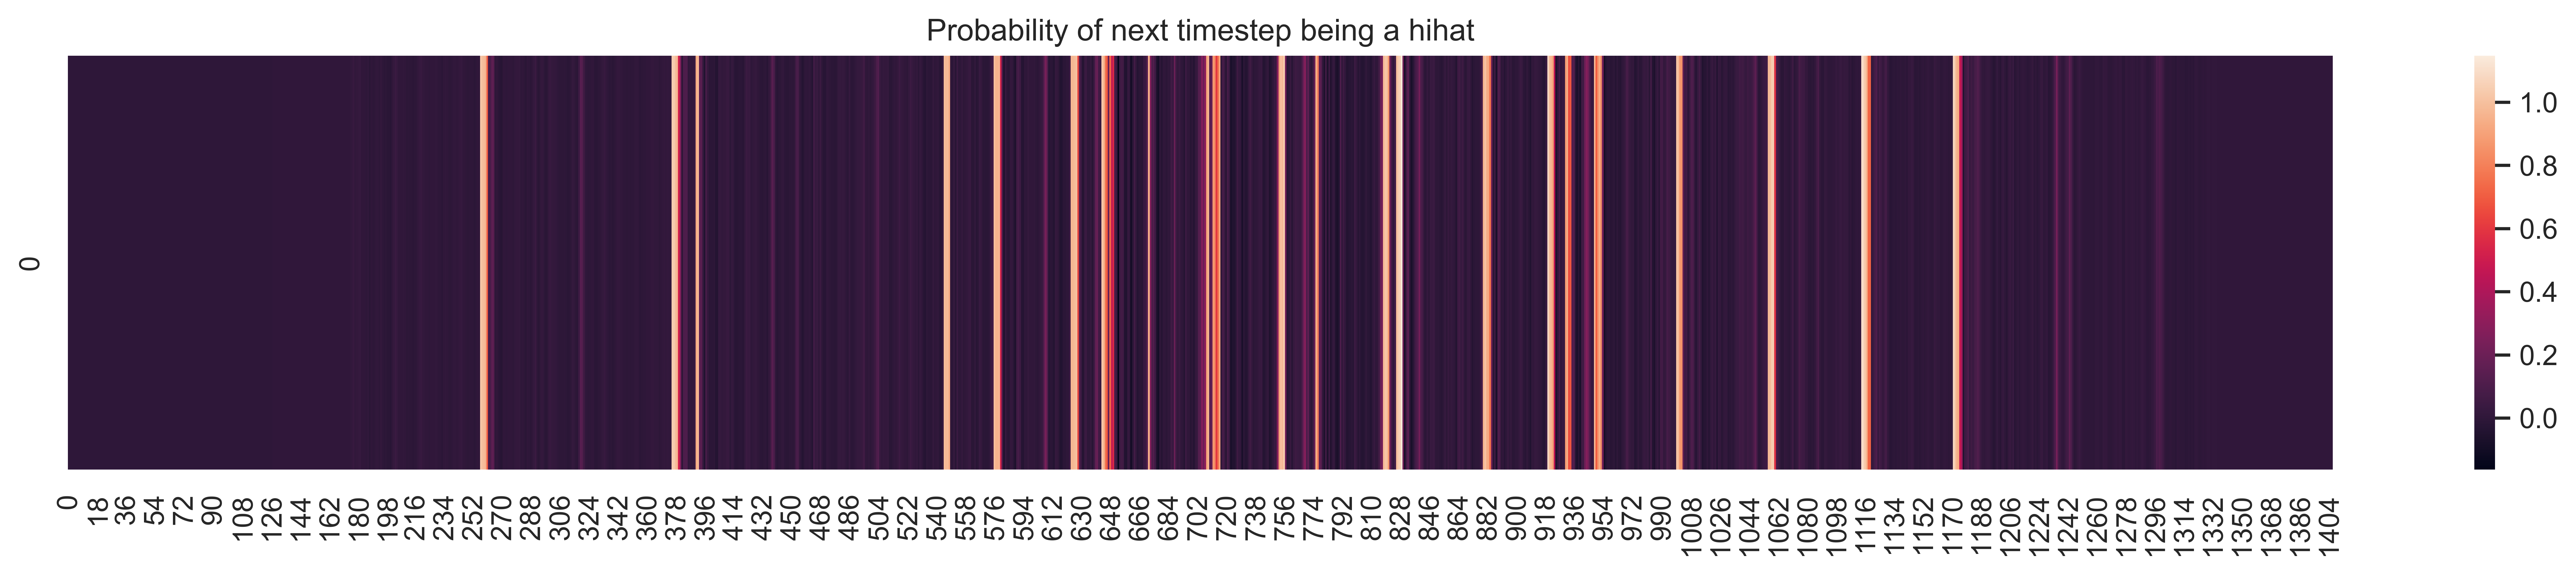

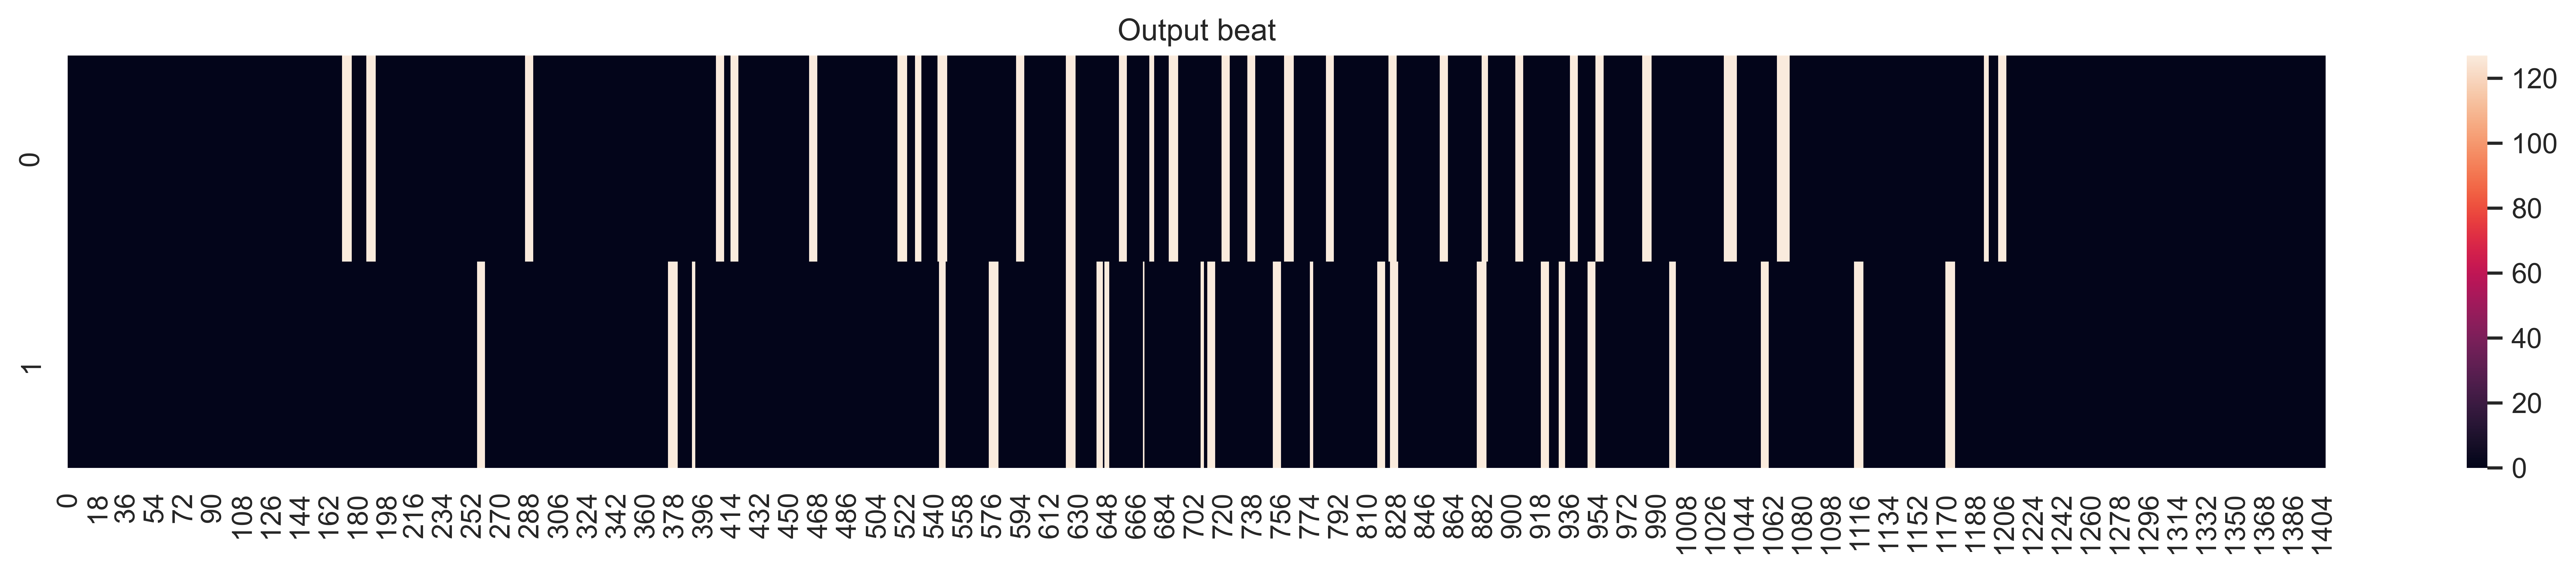

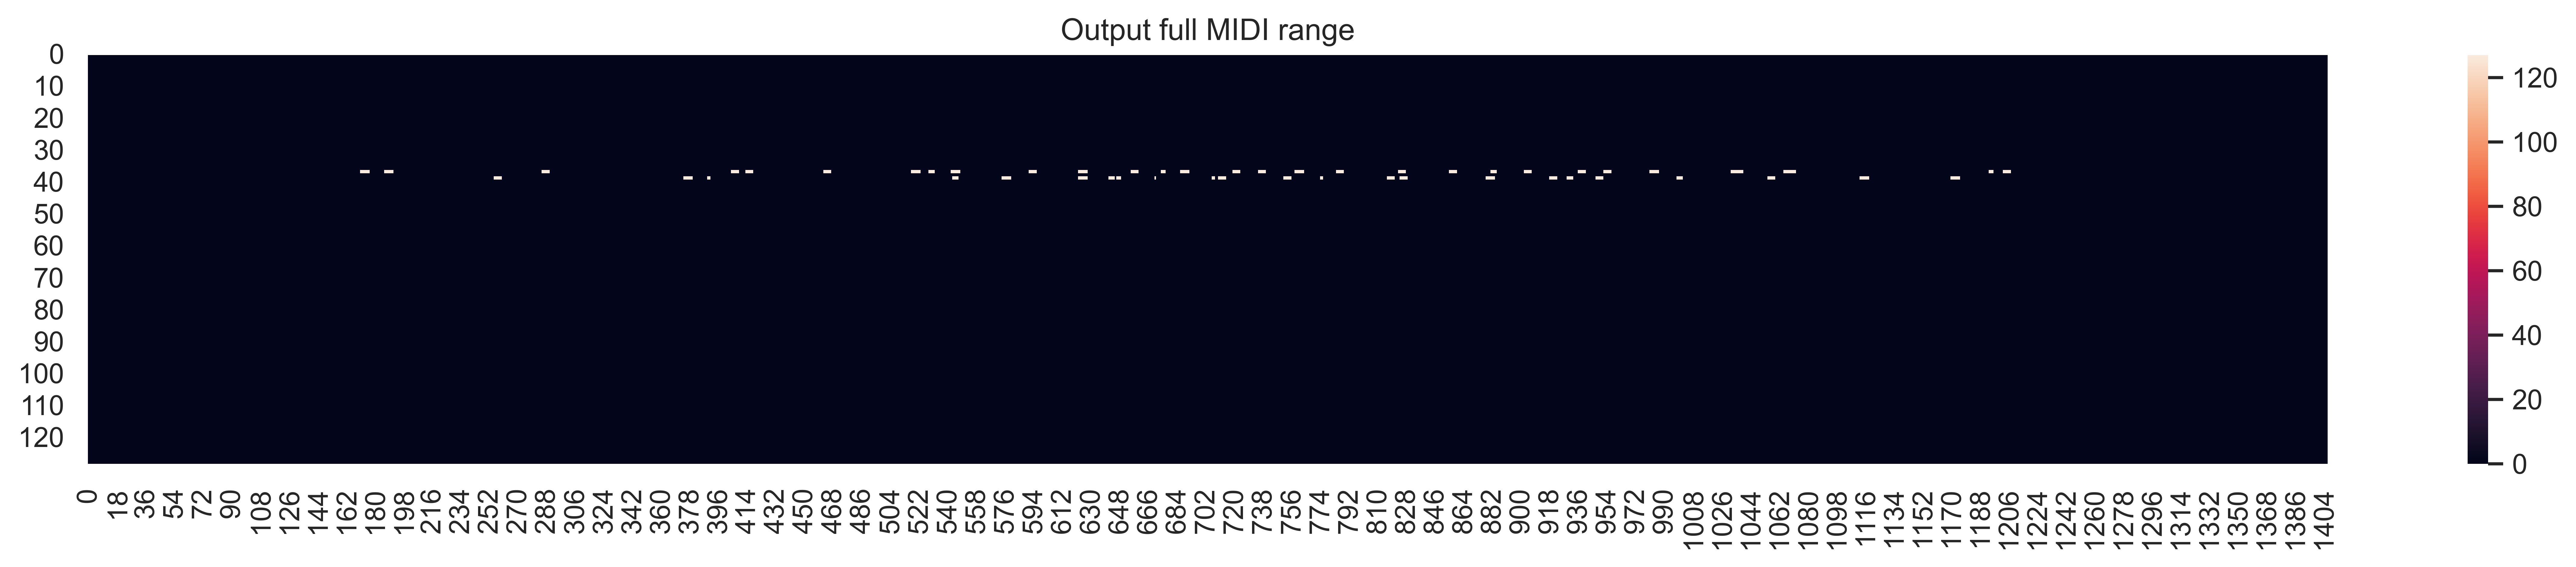

[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]
[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


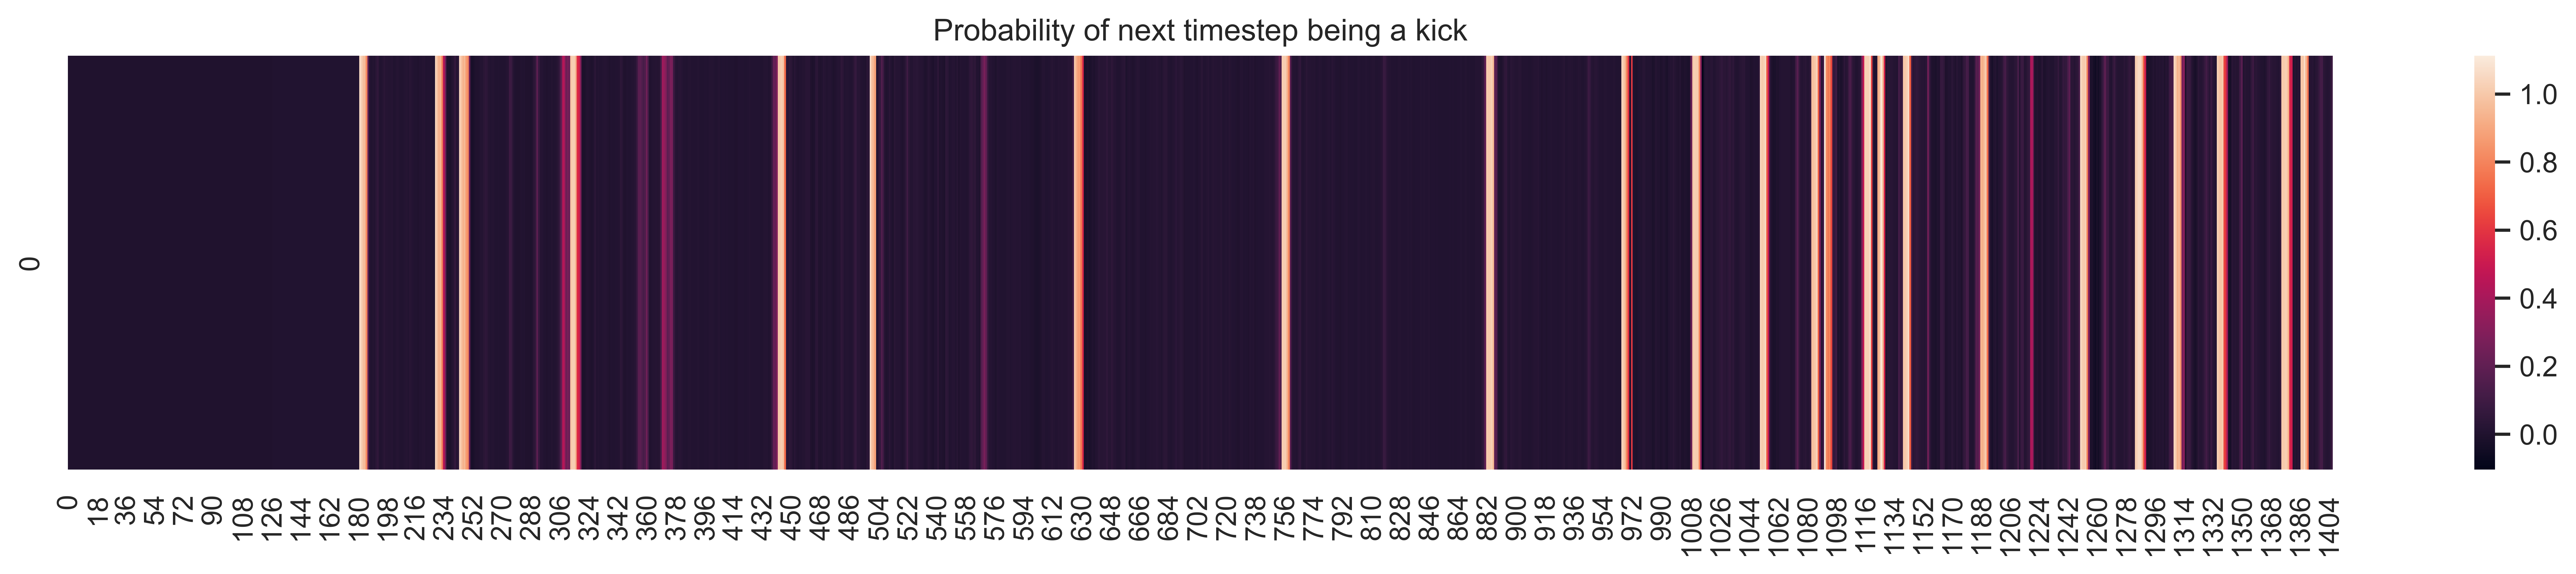

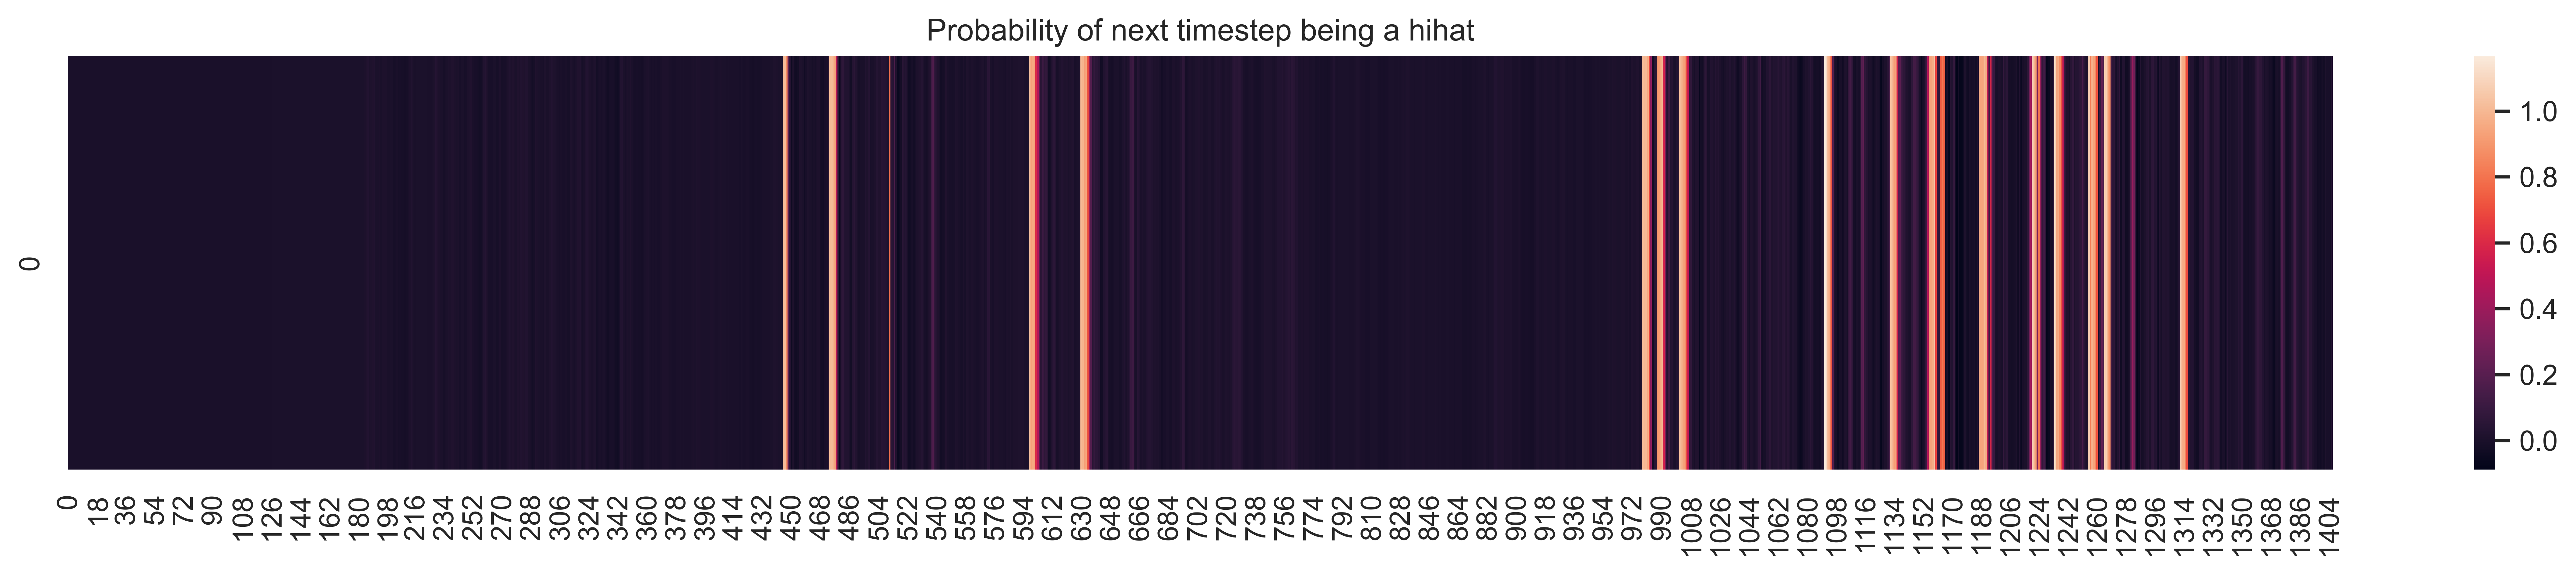

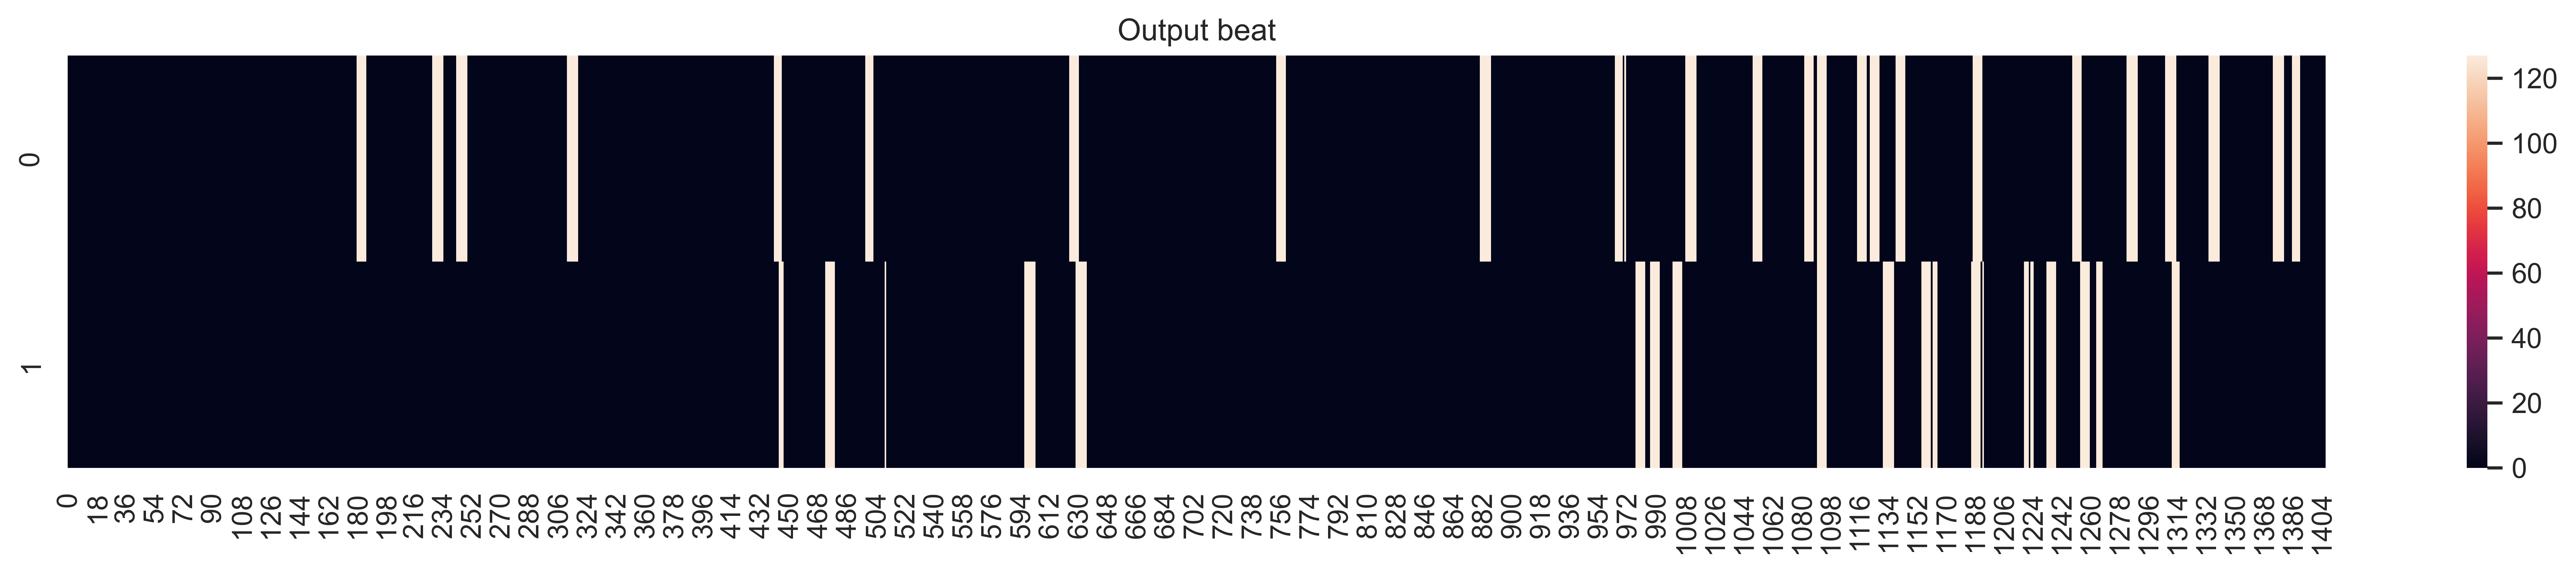

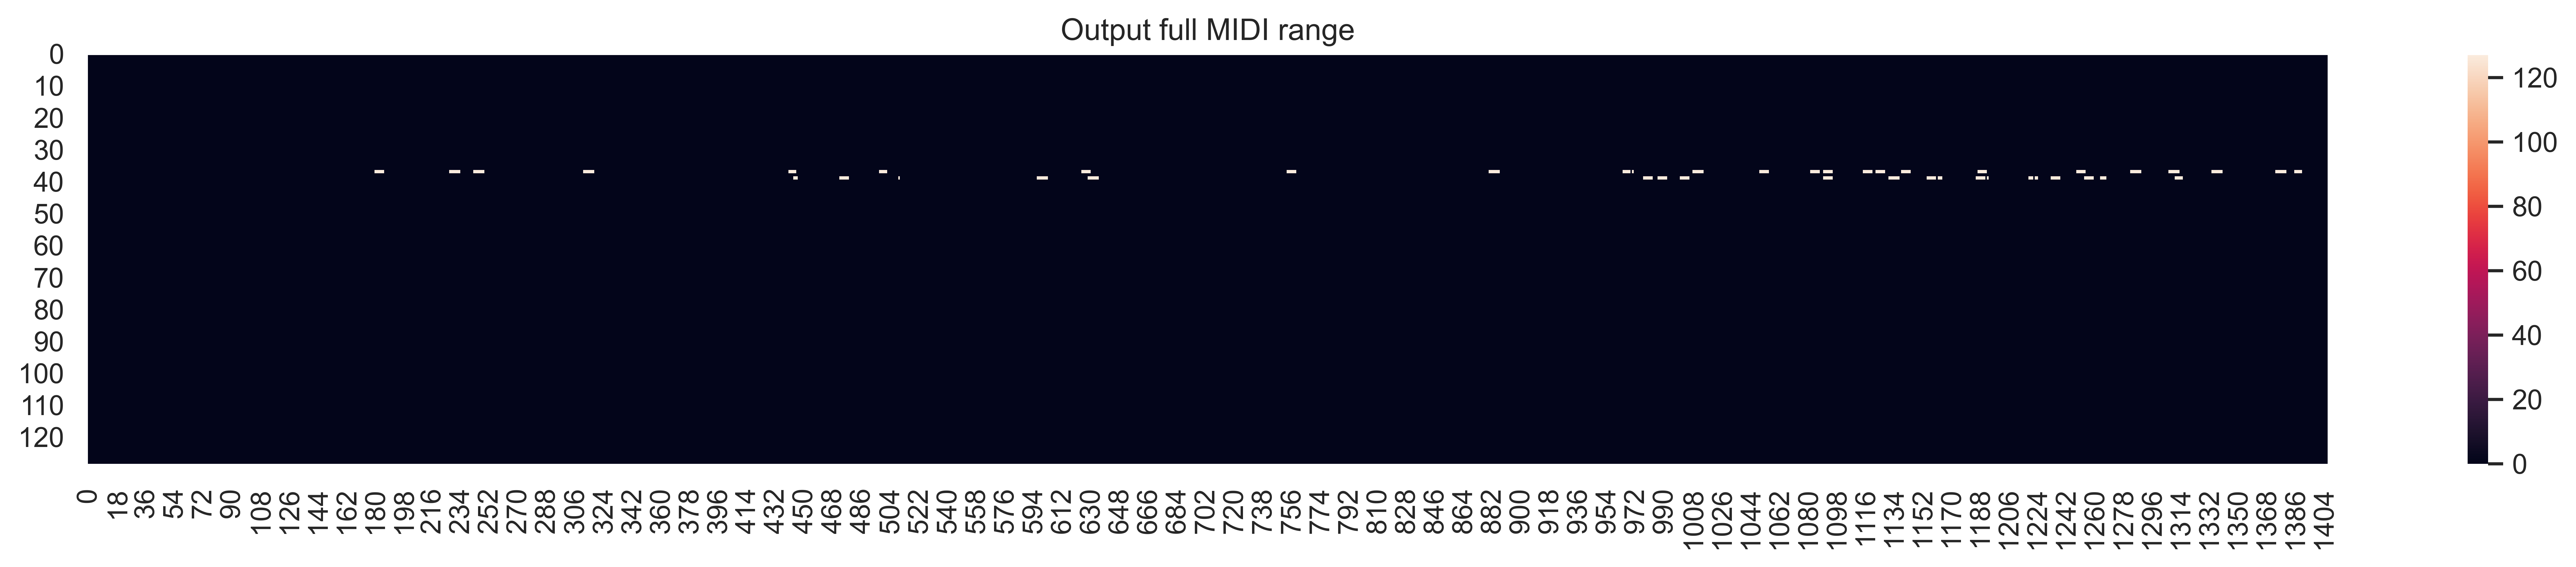

In [45]:
import utils
import write_midi

OUTPUT_BPM = 120

# -------
# Network generating a song

loop_steps = round(QUANTIZE * (120 / 3)) # 20 second beat
window = np.zeros((254))
only_drums_vector = np.zeros((254))

raw_output_only_drums_vector_kick = np.zeros((127))
raw_output_only_drums_vector_hihat = np.zeros((127))

for x in range(loop_steps):
    expanded = np.expand_dims(window, axis=0)
    predictions = net_ker(expanded)

    split_windows = np.split(window, 2)

    split_windows[0] = np.roll(split_windows[0], -1)
    split_windows[1] = np.roll(split_windows[1], -1)

    prediction_kick = 1 if random.random() <  predictions.numpy()[0][0] else 0
    prediction_hihat = 1 if random.random() <  predictions.numpy()[0][1] else 0

    split_windows[0][-1] = round(prediction_kick)
    split_windows[1][-1] = round(prediction_hihat)
    window = np.concatenate((split_windows[0], split_windows[1]))

    only_drums_vector = np.append(only_drums_vector, [prediction_kick, prediction_hihat])

    raw_output_only_drums_vector_kick = np.append(raw_output_only_drums_vector_kick, [predictions.numpy()[0][0]])
    raw_output_only_drums_vector_hihat = np.append(raw_output_only_drums_vector_hihat, [predictions.numpy()[0][1]])


# --------
# Turning the generated song back into MIDI so we can play it

# Read the vector and turn it back into midi
input_only_drums_matrix = np.reshape(only_drums_vector, (int(only_drums_vector.shape[0] / len(DRUM_INDEXES)), len(DRUM_INDEXES)), order='C')


raw_output_input_only_drums_matrix_kick = np.reshape(raw_output_only_drums_vector_kick, (int(raw_output_only_drums_vector_kick.shape[0] / 1), 1), order='C')
raw_output_input_only_drums_matrix_hihat = np.reshape(raw_output_only_drums_vector_hihat, (int(raw_output_only_drums_vector_hihat.shape[0] / 1), 1), order='C')
# We get the 22 column matrix again, but to turn it back into midi we need all 128 columns back
# So we create an empty matrix of the correct 128 column size, and replace our columns
# in that matrix. That way we get a matrix with zeros everywhere except for our pitches.
new_midi_matrix = np.zeros((input_only_drums_matrix.shape[0], 128), dtype=np.int16)
for i in range(len(DRUM_INDEXES)):
    new_column = DRUM_INDEXES[i]
    print(new_midi_matrix[:,new_column])
    print(input_only_drums_matrix[:,i])
    new_midi_matrix[:,new_column] = input_only_drums_matrix[:,i]


input_only_drums_matrix = input_only_drums_matrix * 127
new_midi_matrix = new_midi_matrix * 127

plt.figure(figsize = (20,3))
ax = sns.heatmap(raw_output_input_only_drums_matrix_kick.transpose(), linewidth=0, cmap="rocket").set(title='Probability of next timestep being a kick')
plt.show()

plt.figure(figsize = (20,3))
ax = sns.heatmap(raw_output_input_only_drums_matrix_hihat.transpose(), linewidth=0, cmap="rocket").set(title='Probability of next timestep being a hihat')
plt.show()

plt.figure(figsize = (20,3))
ax = sns.heatmap(input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket").set(title='Output beat')
plt.show()

plt.figure(figsize = (20,3))
ax = sns.heatmap(new_midi_matrix.transpose(), linewidth=0, cmap="rocket").set(title='Output full MIDI range')
plt.show()

# Write our new midi matrix to a file, that we can then play!
new_file = utils.matrix_to_dict(new_midi_matrix)
write_midi.write_midi(new_file, QUANTIZE, "test-song.mid", int(OUTPUT_BPM))

In [ ]:
plt.figure(figsize = (12,2))
ax = sns.heatmap(raw_output_input_only_drums_matrix_kick.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Probability'}).set(xlabel='Timestep')
# ax=plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(32))
plt.savefig('report/2-inst-song-1-probability-kick.png',bbox_inches='tight')

plt.figure(figsize = (12,2))
ax = sns.heatmap(raw_output_input_only_drums_matrix_hihat.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Probability'}).set(xlabel='Timestep')
# ax=plt.gca()
# ax.xaxis.set_major_locator(ticker.MultipleLocator(32))
plt.savefig('report/2-inst-song-1-probability-hihat.png',bbox_inches='tight')

plt.figure(figsize = (12,2))
ax = sns.heatmap(input_only_drums_matrix.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Velocity'}).set(xlabel='Timestep')
plt.savefig('report/2-inst-song-1-beat.png',bbox_inches='tight')

plt.figure(figsize = (12,2))
ax = sns.heatmap(new_midi_matrix.transpose(), linewidth=0, cmap="rocket", yticklabels=False, cbar_kws={'label': 'Velocity'}).set(xlabel='Timestep')
plt.savefig('report/2-inst-song-1-midi.png',bbox_inches='tight')